# BadELF Analysis Example

This notebook demonstrates the BadELF (Bader analysis based on ELF) method for counting electrons in electrides.

**Reference:**
Weaver et al., "Counting Electrons in Electrides", J. Am. Chem. Soc. 2023, 145, 26472-26476

## System: Y₂C (Electride)

Y₂C is a well-known electride material where electrons are localized in interstitial sites between Y atoms.

## Two Ways to Use elfcharge

1. **Easy-Use Wrapper** (`run_badelf_analysis`): One function call for complete analysis
2. **Step-by-Step API**: Fine-grained control over each step

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, '..')

# Import elfcharge modules
from elfcharge import (
    read_elfcar, read_chgcar,
    ELFAnalyzer,
    VoronoiPartitioner,
    create_structure_with_electrides,
    ZVAL
)
from elfcharge.visualize import (
    plot_elf_profiles_by_type,
    plot_radial_elf,
    plot_electron_distribution,
    plot_electride_elf_histogram,
    plot_elf_slice,
    plot_elf_slice_with_partition  # New: partition visualization
)
from scipy.ndimage import zoom

## Option A: Easy-Use Wrapper (Recommended)

Use `run_badelf_analysis()` for a complete analysis in one function call.

In [ ]:
import sys
sys.path.insert(0, '..')

from elfcharge import run_badelf_analysis

# Paths to VASP output files (Y2C electride)
DATA_DIR = '../test/Y2C'

# Run complete BadELF analysis with one function call
result = run_badelf_analysis(
    elfcar_path=f'{DATA_DIR}/ELFCAR',
    chgcar_path=f'{DATA_DIR}/CHGCAR_sum',  # CHGCAR with core electrons
    # ZVAL from POTCAR (Y_sv, C)
    zval={'Y': 11, 'C': 4},
    # Oxidation states for improved CrystalNN accuracy
    oxidation_states={'Y': 3, 'C': -4},
    # Core radii to exclude when finding ELF minima
    core_radii={'Y': 0.8, 'C': 0.3},
    # Electride detection threshold
    elf_threshold=0.5,
    # Apply ELF smoothing for cleaner visualization
    apply_smooth=True,
    smooth_size=3,
    # Output options
    save_dir='./badelf_output',
    save_plots=True,
    save_cif=True,
    verbose=True
)

In [ ]:
# Access results from run_badelf_analysis
print("="*60)
print("Results from run_badelf_analysis()")
print("="*60)

# Species average oxidation states
print("\nSpecies average oxidation states:")
for species, ox in result.oxidation.species_avg_oxidation.items():
    print(f"  {species}: {ox:+.3f}")

# Electride site information
print(f"\nElectride sites found: {len(result.electride_sites)}")
for i, site in enumerate(result.electride_sites):
    electrons = result.charges.electride_electrons[i]
    print(f"  Site {i}: ELF={site.elf_value:.3f}, electrons={electrons:.3f}")

# Total electrons
print(f"\nTotal electrons: {result.total_electrons:.4f}")

# Available output files
print("\nOutput files saved to ./badelf_output/:")
print("  - structure_with_electrides.cif")
print("  - elf_partition_xy.png")
print("  - electron_distribution.png")

## Option B: Step-by-Step API

For more control over the analysis process, use the individual functions.
This approach is useful when you need to customize specific steps or inspect intermediate results.

In [ ]:
# Paths to VASP output files (Y2C electride)
DATA_DIR = '../test/Y2C'
ELFCAR_PATH = f'{DATA_DIR}/ELFCAR'
CHGCAR_PATH = f'{DATA_DIR}/CHGCAR'  # Valence electrons only

# Load data
print("Loading ELFCAR...")
elf_data = read_elfcar(ELFCAR_PATH)

print("Loading CHGCAR...")
chg_data = read_chgcar(CHGCAR_PATH)

print(f"\nStructure info:")
print(f"  Volume: {elf_data.volume:.2f} Å³")
print(f"  Atoms: {elf_data.n_atoms}")
print(f"  Species: {dict(zip(elf_data.species, elf_data.num_atoms))}")
print(f"  ELF grid: {elf_data.ngrid}")
print(f"  CHGCAR grid: {chg_data.ngrid}")

# Check total electrons
total_electrons = np.sum(chg_data.grid) / np.prod(chg_data.ngrid)
print(f"\nTotal electrons in CHGCAR: {total_electrons:.2f}")

## 2. ZVAL Configuration

Define the valence electron counts from POTCAR for oxidation state calculation.

In [ ]:
# ZVAL from POTCAR
# Y: PAW_PBE Y_sv (ZVAL=11: 4s²4p⁶4d¹5s²)
# C: PAW_PBE C (ZVAL=4: 2s²2p²)

ZVAL_CONFIG = {
    'Y': 11,
    'C': 4
}

# Expected total valence electrons
expected = sum(n * ZVAL_CONFIG.get(sp, 0) 
               for sp, n in zip(elf_data.species, elf_data.num_atoms))
print(f"Expected valence electrons: {expected}")
print(f"Actual: {total_electrons:.2f}")

## 3. Find Electride Sites

Electride sites are interstitial ELF maxima that are:
- Far from all atomic nuclei
- Have high ELF values (> threshold)

In [ ]:
# Initialize analyzer
analyzer = ELFAnalyzer(elf_data)

# Find interstitial electride sites
# atom_cutoffs: distance threshold to consider a point as interstitial
electride_sites = analyzer.find_interstitial_electrides(
    elf_threshold=0.5,
    atom_cutoff=1.0,
    atom_cutoffs={'Y': 1.0, 'C': 0.8}  # Smaller cutoff for C
)

print(f"Found {len(electride_sites)} electride sites")
print("\nElectride site details:")
for i, site in enumerate(sorted(electride_sites, key=lambda x: -x.elf_value)):
    print(f"  Site {i}: ELF = {site.elf_value:.3f}, position = {site.frac_coord}")

## 4. Analyze Bond ELF Profiles

Find ELF minima along bonds for partitioning.

In [ ]:
# Get neighbor pairs using CrystalNN
bonds = analyzer.get_neighbor_pairs_pymatgen()
print(f"Found {len(bonds)} neighbor pairs")

# Analyze ELF along each bond
# core_radii: exclude atomic core regions when finding ELF minima
core_radii = {'Y': 0.8, 'C': 0.3}

for i, bond in enumerate(bonds):
    bonds[i] = analyzer.analyze_bond_elf(bond, core_radii=core_radii)

n_with_min = sum(1 for b in bonds if b.elf_minimum_frac is not None)
print(f"Bonds with ELF minima: {n_with_min}")

# Compute atomic radii from ELF minima
atom_radii = analyzer.compute_atom_radii(bonds)
species_list = elf_data.get_species_list()

print("\nAtomic radii (from ELF minima):")
for sp in sorted(set(species_list)):
    indices = [i for i, s in enumerate(species_list) if s == sp]
    radii = [atom_radii[i].boundary_radius for i in indices 
             if atom_radii[i] and atom_radii[i].boundary_radius]
    if radii:
        print(f"  {sp}: {np.mean(radii):.3f} ± {np.std(radii):.3f} Å")

Saved elf_profiles.png


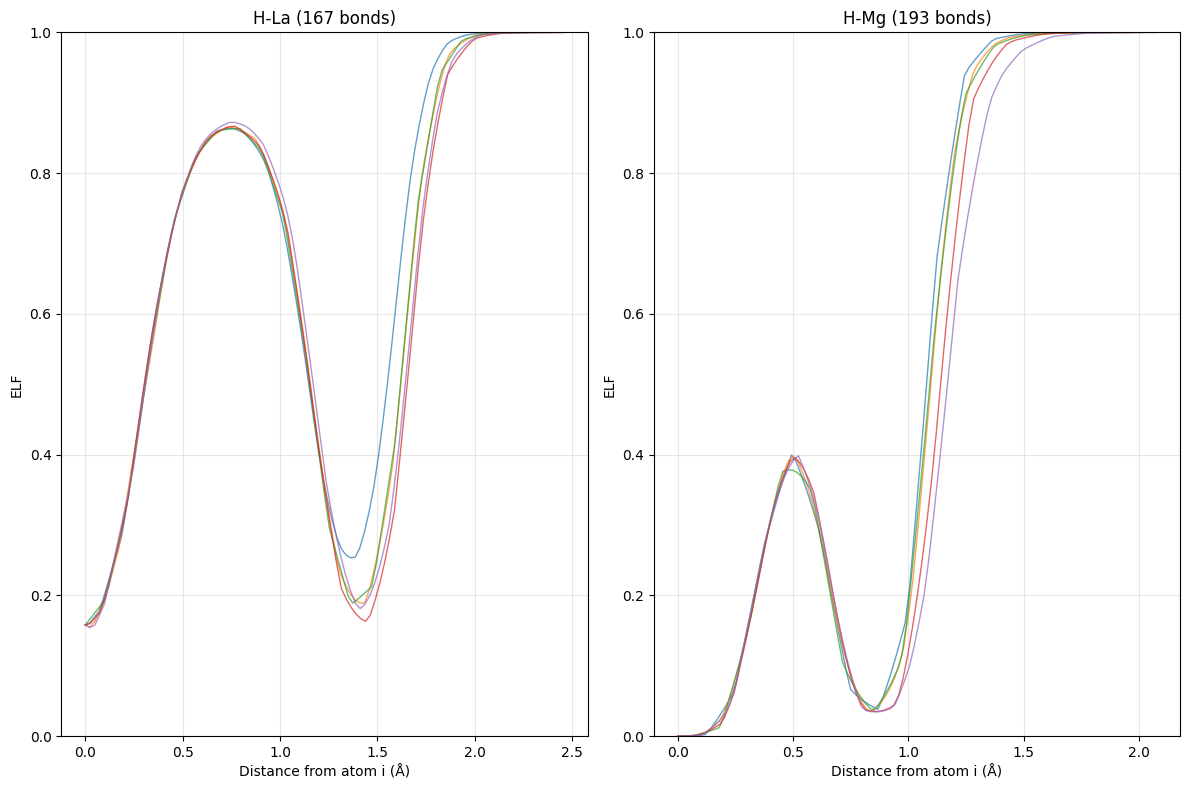

In [7]:
# Visualize ELF profiles
fig = plot_elf_profiles_by_type(elf_data, bonds)
fig.savefig('elf_profiles.png', dpi=150)
print("Saved elf_profiles.png")

## 5. Spatial Partitioning

Partition space using ELF-based boundaries:
- Atom-atom: plane at ELF minimum perpendicular to bond
- Atom-electride: simple Voronoi

In [8]:
n_atoms = elf_data.n_atoms
n_electride = len(electride_sites)
ngx, ngy, ngz = elf_data.ngrid
lattice = elf_data.lattice

# Create extended coordinate list (atoms + electrides)
all_frac_coords = np.vstack([
    elf_data.frac_coords,
    np.array([site.frac_coord for site in electride_sites])
])

# Simple Voronoi partitioning first
fx = np.linspace(0, 1, ngx, endpoint=False)
fy = np.linspace(0, 1, ngy, endpoint=False)
fz = np.linspace(0, 1, ngz, endpoint=False)
FX, FY, FZ = np.meshgrid(fx, fy, fz, indexing='ij')
grid_frac = np.stack([FX, FY, FZ], axis=-1)

min_dist_sq = np.full((ngx, ngy, ngz), np.inf)
labels = np.zeros((ngx, ngy, ngz), dtype=np.int32)

n_total = n_atoms + n_electride
for i in range(n_total):
    site_frac = all_frac_coords[i]
    diff = grid_frac - site_frac
    diff = diff - np.round(diff)  # Minimum image
    diff_cart = np.einsum('...j,jk->...k', diff, lattice)
    dist_sq = np.sum(diff_cart ** 2, axis=-1)
    
    closer = dist_sq < min_dist_sq
    labels[closer] = i
    min_dist_sq[closer] = dist_sq[closer]

print(f"Partitioning complete")
print(f"  Unique labels: {len(np.unique(labels))}")

Partitioning complete
  Unique labels: 152


In [9]:
# Apply ELF plane adjustments for atom-atom boundaries
processed_pairs = set()

for bond in bonds:
    if bond.elf_minimum_frac is None:
        continue
    
    bi, bj = bond.atom_i, bond.atom_j
    pair = (min(bi, bj), max(bi, bj))
    if pair in processed_pairs:
        continue
    processed_pairs.add(pair)
    
    # Only adjust points currently assigned to i or j
    mask_i = labels == bi
    mask_j = labels == bj
    mask_bond = mask_i | mask_j
    
    if not np.any(mask_bond):
        continue
    
    # Bond vector and ELF minimum position
    frac_i = elf_data.frac_coords[bi]
    frac_j = elf_data.frac_coords[bj] + np.array(bond.jimage)
    min_frac = bond.elf_minimum_frac
    
    bond_vec_frac = frac_j - frac_i
    bond_len_sq_frac = np.dot(bond_vec_frac, bond_vec_frac)
    if bond_len_sq_frac < 1e-10:
        continue
    
    t_min = np.dot(min_frac - frac_i, bond_vec_frac) / bond_len_sq_frac
    
    # Reassign based on ELF minimum plane
    diff_frac = grid_frac[mask_bond] - frac_i
    diff_frac = diff_frac - np.round(diff_frac)
    t_points = np.einsum('...k,k->...', diff_frac, bond_vec_frac) / bond_len_sq_frac
    
    on_j_side = t_points > t_min
    on_i_side = t_points < t_min
    
    mask_bond_indices = np.where(mask_bond)
    mask_i_in_bond = labels[mask_bond] == bi
    mask_j_in_bond = labels[mask_bond] == bj
    
    reassign_to_j = mask_i_in_bond & on_j_side
    reassign_to_i = mask_j_in_bond & on_i_side
    
    if np.any(reassign_to_j):
        idx = tuple(arr[reassign_to_j] for arr in mask_bond_indices)
        labels[idx] = bj
    
    if np.any(reassign_to_i):
        idx = tuple(arr[reassign_to_i] for arr in mask_bond_indices)
        labels[idx] = bi

print(f"ELF plane adjustments applied to {len(processed_pairs)} bond pairs")

ELF plane adjustments applied to 360 bond pairs


## 6. Charge Integration

In [10]:
# Resample labels to CHGCAR grid if needed
if elf_data.ngrid != chg_data.ngrid:
    zoom_factors = tuple(t / s for t, s in zip(chg_data.ngrid, elf_data.ngrid))
    labels_resampled = zoom(labels.astype(float), zoom_factors, order=0).astype(int)
else:
    labels_resampled = labels

chg_grid = chg_data.grid
n_grid = np.prod(chg_data.ngrid)

# Integrate for atoms
atom_electrons = np.zeros(n_atoms)
for i in range(n_atoms):
    mask = labels_resampled == i
    atom_electrons[i] = np.sum(chg_grid[mask]) / n_grid

# Integrate for electride sites
electride_electrons = np.zeros(n_electride)
for i in range(n_electride):
    mask = labels_resampled == (n_atoms + i)
    electride_electrons[i] = np.sum(chg_grid[mask]) / n_grid

# Calculate oxidation states
atom_oxidation = np.zeros(n_atoms)
for i, sp in enumerate(species_list):
    ref = ZVAL_CONFIG.get(sp, 0)
    atom_oxidation[i] = ref - atom_electrons[i]

print(f"Total electrons: {np.sum(atom_electrons) + np.sum(electride_electrons):.4f}")

Total electrons: 528.0000


## 7. Results

In [11]:
print("="*60)
print("RESULTS")
print("="*60)

print("\nSpecies average oxidation states:")
print("-"*50)
species_stats = {}
for sp in sorted(set(species_list)):
    indices = [i for i, s in enumerate(species_list) if s == sp]
    avg_e = np.mean([atom_electrons[i] for i in indices])
    std_e = np.std([atom_electrons[i] for i in indices])
    avg_ox = np.mean([atom_oxidation[i] for i in indices])
    std_ox = np.std([atom_oxidation[i] for i in indices])
    ref = ZVAL_CONFIG.get(sp, 0)
    species_stats[sp] = {'count': len(indices), 'mean_ox': avg_ox, 'ref': ref}
    print(f"  {sp:3s}: {avg_ox:+6.3f} ± {std_ox:.3f}  (electrons: {avg_e:.2f} ± {std_e:.2f}, ZVAL={ref})")

print("\nElectride sites:")
print("-"*50)
total_e_electride = 0
for i, (site, e) in enumerate(sorted(zip(electride_sites, electride_electrons), 
                                       key=lambda x: -x[1])):
    print(f"  Site {i}: {e:.4f} electrons (ELF = {site.elf_value:.3f})")
    total_e_electride += e
print(f"\n  Total electride electrons: {total_e_electride:.4f}")

RESULTS

Species average oxidation states:
--------------------------------------------------
  H  : -0.855 ± 0.049  (electrons: 1.86 ± 0.05, ZVAL=1)
  La : +2.171 ± 0.038  (electrons: 8.83 ± 0.04, ZVAL=11)
  Mg : +1.731 ± 0.045  (electrons: 6.27 ± 0.05, ZVAL=8)

Electride sites:
--------------------------------------------------
  Site 0: 1.0942 electrons (ELF = 0.949)
  Site 1: 1.0550 electrons (ELF = 0.930)
  Site 2: 1.0433 electrons (ELF = 0.947)
  Site 3: 1.0257 electrons (ELF = 0.938)
  Site 4: 0.9960 electrons (ELF = 0.866)
  Site 5: 0.9944 electrons (ELF = 0.901)
  Site 6: 0.9547 electrons (ELF = 0.770)
  Site 7: 0.8746 electrons (ELF = 0.901)

  Total electride electrons: 8.0378


In [12]:
# Charge neutrality check
print("\nCharge neutrality check:")
print("-"*50)
total_charge = 0.0
print("  Contribution by species:")
for sp, stats in species_stats.items():
    contrib = stats['count'] * stats['mean_ox']
    total_charge += contrib
    print(f"    {sp}: {stats['count']} × ({stats['mean_ox']:+.3f}) = {contrib:+.3f}")

electride_charge = -total_e_electride
print(f"    Electride: {n_electride} sites = {electride_charge:+.3f}")
total_charge += electride_charge

print(f"\n  Total charge (should be 0): {total_charge:+.4f}")


Charge neutrality check:
--------------------------------------------------
  Contribution by species:
    H: 96 × (-0.855) = -82.082
    La: 16 × (+2.171) = +34.741
    Mg: 32 × (+1.731) = +55.379
    Electride: 8 sites = -8.038

  Total charge (should be 0): -0.0000


## 8. Export Structure with Electride Sites

In [13]:
# Create structure with electride sites as dummy atoms
structure = create_structure_with_electrides(
    elf_data,
    electride_sites,
    electride_symbol="X",  # Dummy atom
    electride_electrons=electride_electrons
)

print(f"Structure created with {structure.num_sites} sites")
print(f"  Atoms: {n_atoms}")
print(f"  Electride sites: {n_electride}")

# Export to CIF
structure.to(filename="structure_with_electrides.cif", fmt="cif")
print("\nExported to structure_with_electrides.cif")

Structure created with 152 sites
  Atoms: 144
  Electride sites: 8

Exported to structure_with_electrides.cif


<cell_type>markdown</cell_type>## 9. Visualization

### 9.1 ELF Slice with Partition Boundaries

Visualize the ELF distribution with Voronoi partition boundaries overlaid.

**Key parameters:**
- `interpolate=True`: Enable bicubic interpolation for smoother images
- `interpolate_factor`: Resolution multiplier (e.g., 3 = 3x resolution)
- `coord_system`: 'cartesian' (Å) or 'fractional' (0-1)
- Atom/electride display: symbol, size, color, labels

In [ ]:
# Plot ELF slice with partition boundaries (Cartesian coordinates, interpolated)
fig = plot_elf_slice_with_partition(
    elf_data, labels,
    plane='xy', position=0.5,
    electride_sites=electride_sites,
    # High resolution with interpolation
    interpolate=True,
    interpolate_factor=3,
    # Coordinate system: 'cartesian' (Å) or 'fractional'
    coord_system='cartesian',
    # Atom display options
    show_atoms=True,
    show_atom_symbol=True,
    atom_symbol='o',
    atom_symbol_size=200,
    atom_symbol_color={'La': '#4169E1', 'Mg': '#32CD32', 'H': '#FF6347'},
    # Element label options
    show_element_label=True,
    element_label_size=10,
    element_label_color='black',
    # Electride display options
    show_electrides=True,
    electride_symbol='*',
    electride_symbol_size=300,
    electride_symbol_color='yellow',
    electride_label='e⁻',
    electride_label_size=10,
    electride_label_color='black',
)
fig.savefig('elf_partition_cartesian.png', dpi=150)
plt.show()
print("Saved elf_partition_cartesian.png")

In [ ]:
# Plot ELF slice with partition boundaries (Fractional coordinates)
fig = plot_elf_slice_with_partition(
    elf_data, labels,
    plane='xy', position=0.5,
    electride_sites=electride_sites,
    interpolate=True,
    interpolate_factor=3,
    coord_system='fractional',  # Fractional coordinates (0-1)
)
fig.savefig('elf_partition_fractional.png', dpi=150)
plt.show()
print("Saved elf_partition_fractional.png")

In [ ]:
# Different planes (xz, yz)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# XZ plane
fig_xz = plot_elf_slice_with_partition(
    elf_data, labels,
    plane='xz', position=0.5,
    electride_sites=electride_sites,
    interpolate=True,
    interpolate_factor=2,
    coord_system='cartesian',
)
fig_xz.savefig('elf_partition_xz.png', dpi=150)
plt.show()

# YZ plane
fig_yz = plot_elf_slice_with_partition(
    elf_data, labels,
    plane='yz', position=0.5,
    electride_sites=electride_sites,
    interpolate=True,
    interpolate_factor=2,
    coord_system='cartesian',
)
fig_yz.savefig('elf_partition_yz.png', dpi=150)
plt.show()

print("Saved elf_partition_xz.png and elf_partition_yz.png")

<cell_type>markdown</cell_type>### 9.2 Radial ELF Profiles and Statistics

In [ ]:
# Plot radial ELF around La atom
fig, ax = plt.subplots(figsize=(8, 5))
la_indices = [i for i, s in enumerate(species_list) if s == 'La']
plot_radial_elf(elf_data, la_indices[0], r_max=3.0, ax=ax)
fig.savefig('la_radial_elf.png', dpi=150)
plt.show()
print("Saved la_radial_elf.png")

Saved electron_distribution.png


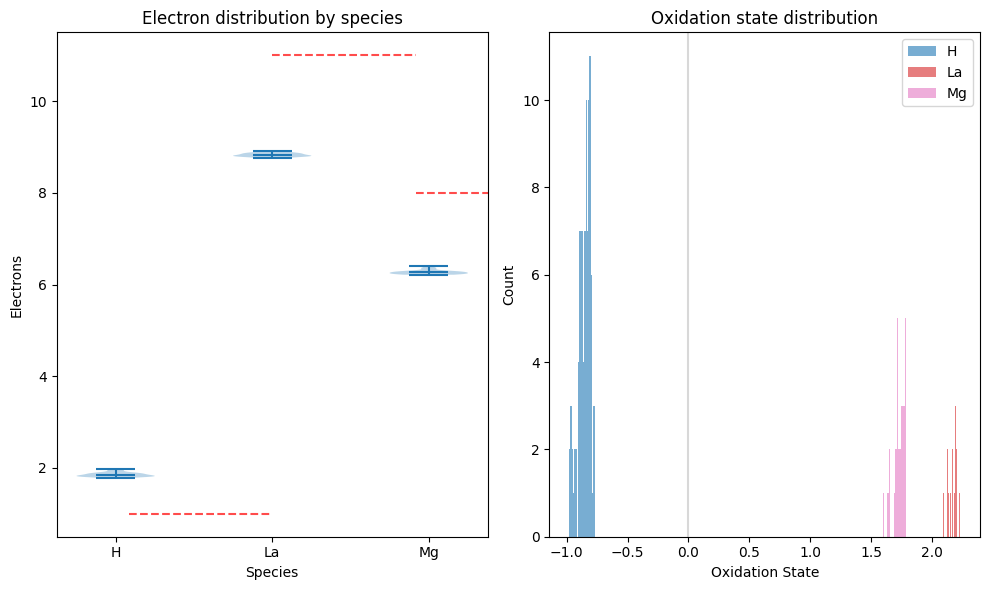

In [16]:
# Plot electron distribution
fig = plot_electron_distribution(atom_electrons, species_list, reference=ZVAL_CONFIG)
fig.savefig('electron_distribution.png', dpi=150)
print("Saved electron_distribution.png")

Saved electride_stats.png


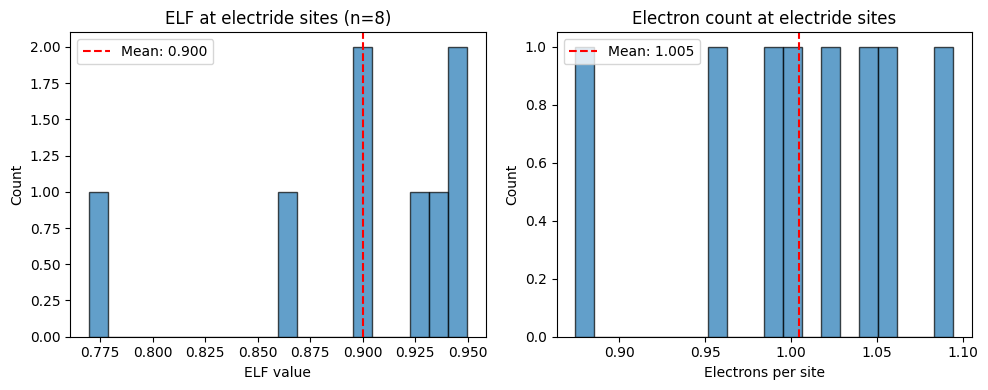

In [17]:
# Plot electride site statistics
fig = plot_electride_elf_histogram(electride_sites, electride_electrons)
fig.savefig('electride_stats.png', dpi=150)
print("Saved electride_stats.png")

Saved elf_slice.png


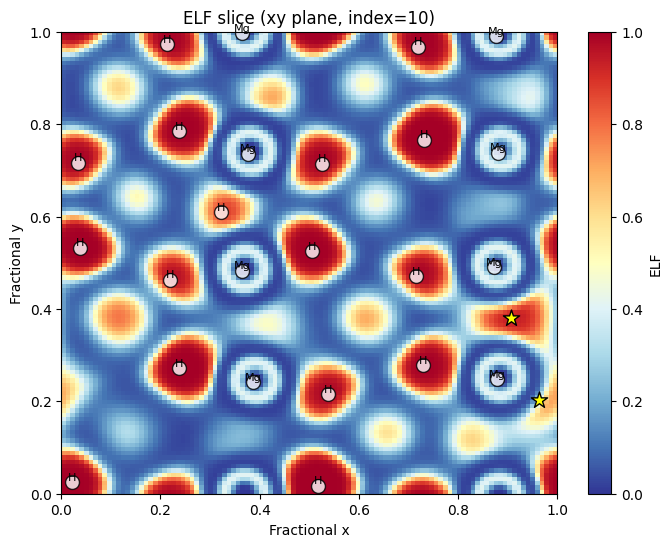

In [19]:
# Plot ELF slice
fig = plot_elf_slice(elf_data, plane='xy', position=0.125, 
                     electride_sites=electride_sites)
fig.savefig('elf_slice.png', dpi=150)
print("Saved elf_slice.png")

## Summary

This notebook demonstrated:

1. **Loading VASP output files** (ELFCAR, CHGCAR)
2. **Finding electride sites** from interstitial ELF maxima
3. **Analyzing bond ELF profiles** to find partitioning boundaries
4. **Spatial partitioning** using ELF-based planes
5. **Charge integration** for atoms and electride sites
6. **Oxidation state calculation** and charge neutrality check
7. **Structure export** with electride sites as dummy atoms
8. **Visualization** of ELF and electron distributions

### Notes for Y₂C Analysis

- Y₂C is a classic electride with electrons localized between Y layers
- Expected oxidation states: Y ≈ +2 to +2.5, C ≈ -4
- Electride electrons contribute ~2e⁻ per formula unit